### Import required modules

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import cartopy.feature as cfeatures
from scipy.stats import linregress
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xskillscore as xs
from scipy.stats import t
import matplotlib.dates as mdates
import pandas as pd
from scipy import stats
from scipy.ndimage import label
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from datetime import datetime


### Function

In [2]:
## Function to select JJAS values

def is_jjas(month):
    return (month >= 6) & (month <= 9)

def calculate_seasonal_means_precip(ds):
    seasonal_var = ds.sel(time=is_jjas(ds['time.month']))

    return seasonal_var

## Function to calculate trend and p-values

def linear_trend(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope, p_value

## Function to detrend along a dimension

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## Function to perform linear regression

def linear_regression(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    return slope

## Function to perform linear regression and output p value

def linear_regression_p(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope,p_value

### Load data and rename coordinates if required

In [3]:
file_names = {
    
    'ds_precip': '../Data/Observations/IMD/IMD_rainfall_1951_2022.nc',
    'ds_quv': '../Data/Observations/ERA5/ERA5_q_u_v_200_850hpa_1m_1979_2022.nc',
    'ds_mois' : '../Data/Observations/ERA5/era5_moisture_transport.nc',
    'ds_mslp': '../Data/Observations/ERA5/ERA5_MSLP_1m_1979_2022.nc',
    'ds_sst': '../Data/Observations/Hadley/HadISST_sst.nc',
    'ds_evp': '../Data/Observations/ERA5/era5_sst_evp_windspeed.nc',
    'ds_evp_oa': '../Data/Observations/OAflux/OAflux_evaporation_1958_2022.nc'
}

for key, file_name in file_names.items():
    dataset = xr.open_dataset(file_name)
    
    # Handle different time variable names
    if 'time' in dataset:
        time_var = 'time'
    elif 'TIME' in dataset:
        time_var = 'TIME'
    else:
        print(f"Unexpected time variable name in {file_name}")
        continue

    dataset = dataset.sel({time_var: slice('1979','2022')})

    # Handle different longitude variable names
    if 'longitude' in dataset:
        lon_var = 'longitude'
    elif 'lon' in dataset:
        lon_var = 'lon'
    elif 'LONN179_180' in dataset:
        lon_var = 'LONN179_180'
    elif 'LONGITUDE' in dataset:
        lon_var = 'LONGITUDE'
    elif 'LON7_40' in dataset:
        lon_var = 'LON7_40'
    else:
        print(f"Unexpected longitude variable name in {file_name}")
        continue

    if 'latitude' in dataset:
        lat_var = 'latitude'
    elif 'lat' in dataset:
        lat_var = 'lat'
    elif 'LAT' in dataset:
        lat_var = 'LAT'
    elif 'LATITUDE' in dataset:
        lat_var = 'LATITUDE'
    elif 'LAT6_40' in dataset:
        lat_var = 'LAT6_40'
    else:
        print(f"Unexpected longitude variable name in {file_name}")
        continue

    globals()[key] = dataset.rename({lon_var: 'lon', lat_var: 'lat',time_var:'time'})



C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'rasterio' loading failed:
module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
C:\Users\li3n23\AppData\Local\Temp\ipykernel_22168\2648938793.py:56: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  globals()[key] = dataset.rename({lon_var: 'lon', lat_var: 'lat',time_var:'time'})
C:

In [4]:
cmip_tp = xr.open_dataset('../Data/CMIP6/cmip6_jjas_tp_ssp85_longterm_rel_1850_1900.nc')

### Extract JJAS data

In [188]:
precip_jjas = (calculate_seasonal_means_precip(ds_precip.RAINFALL)).groupby('time.year').sum()
u_jjas = (calculate_seasonal_means_precip(ds_quv.u.sel(level=850))).groupby('time.year').mean()
v_jjas = (calculate_seasonal_means_precip(ds_quv.v.sel(level=850))).groupby('time.year').mean()
mois_jjas = (calculate_seasonal_means_precip(ds_mois)).groupby('time.year').mean()
um_jjas=mois_jjas['p71.162']
vm_jjas=mois_jjas['p72.162']
mois_mag_jjas = np.sqrt(mois_jjas['p71.162']*mois_jjas['p71.162']+mois_jjas['p72.162']*mois_jjas['p72.162'])
wind_speed = np.sqrt(u_jjas**2 + v_jjas**2)
mslp_jjas = (calculate_seasonal_means_precip(ds_mslp.msl.sel(expver=1))).groupby('time.year').mean()
sst_jjas = (calculate_seasonal_means_precip(ds_sst.sst)).groupby('time.year').mean()
q_jjas = (calculate_seasonal_means_precip(ds_quv.q.sel(level=850))).groupby('time.year').mean()
evp_jjas = (calculate_seasonal_means_precip(ds_evp.mer)).groupby('time.year').mean()
evp_jjas_oa = (calculate_seasonal_means_precip(ds_evp_oa.EVAPR)).groupby('time.year').mean()
UQ=wind_speed.sel(lat=slice(30,-50),lon=slice(40,3000))*q_jjas.sel(lat=slice(30,-50),lon=slice(40,300))

In [191]:
sst_jjas['lon'] = xr.where(sst_jjas['lon'] < 0, sst_jjas['lon'] + 360, sst_jjas['lon'])
sst_jjas = sst_jjas.sortby('lon')

evp_jjas_oa['lon'] = xr.where(evp_jjas_oa['lon'] < 0, evp_jjas_oa['lon'] + 360, evp_jjas_oa['lon'])
evp_jjas_oa = evp_jjas_oa.sortby('lon')


### Calculate the percentage increase of precipitation over western Indian region

In [178]:
precip_jjas_yr = precip_jjas.sel(lat=slice(21,28),lon=slice(69,77)).mean(dim=['lat', 'lon'])
evp_jjas_yr = evp_jjas.sel(lat=slice(28,21),lon=slice(69,77)).mean(dim=['lat', 'lon'])
slope_WI, intercept_WI, r_value_WI, p_value_WI, std_err_WI = linregress(precip_jjas_yr.year, precip_jjas_yr)
trend_WI = intercept_WI + slope_WI * precip_jjas_yr.year
slope_evp_WI, intercept_evp_WI, r_value_evp_WI, p_value_evp_WI, std_err_evp_WI = linregress(evp_jjas_yr.year, evp_jjas_yr)
trend_evp_WI = intercept_evp_WI + slope_evp_WI * evp_jjas_yr.year
precip_increase = (slope_WI*44*100)/precip_jjas_yr.sel(year=slice(1979,1988)).mean('year')
evp_increase = (slope_evp_WI*44*100)/evp_jjas_yr.sel(year=slice(1979,1988)).mean('year')

rounded_precip_increase = np.round(precip_increase)
rounded_evp_increase = np.round(evp_increase)

print(f"The precipitation over the NWI region has increased by approximately {rounded_precip_increase.values}%.")
print(f"The evaporation over the NWI region has increased by approximately {rounded_evp_increase.values}%.")

The precipitation over the NWI region has increased by approximately 40.0%.
The evaporation over the NWI region has increased by approximately 11.0%.


### Compute the trend

In [79]:

precip_trend, precip_p_value = xr.apply_ufunc(linear_trend, precip_jjas['year'], precip_jjas,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])


um_trend, um_p_value = xr.apply_ufunc(linear_trend, um_jjas['year'], um_jjas,
                                     input_core_dims=[['year'], ['year']],
                                     vectorize=True, dask='allowed', output_core_dims=[[], []])

vm_trend, vm_p_value = xr.apply_ufunc(linear_trend, vm_jjas['year'], vm_jjas,
                                     input_core_dims=[['year'], ['year']],
                                     vectorize=True, dask='allowed', output_core_dims=[[], []])

ms_trend, ms_p_value = xr.apply_ufunc(linear_trend, mois_mag_jjas['year'],mois_mag_jjas,
                                       input_core_dims=[['year'], ['year']],
                                       vectorize=True, dask='allowed', output_core_dims=[[], []])

u_trend, u_p_value = xr.apply_ufunc(linear_trend, u_jjas['year'], u_jjas,
                                     input_core_dims=[['year'], ['year']],
                                     vectorize=True, dask='allowed', output_core_dims=[[], []])

v_trend, v_p_value = xr.apply_ufunc(linear_trend, v_jjas['year'], v_jjas,
                                     input_core_dims=[['year'], ['year']],
                                     vectorize=True, dask='allowed', output_core_dims=[[], []])

ws_trend, ws_p_value = xr.apply_ufunc(linear_trend, wind_speed['year'], wind_speed,
                                       input_core_dims=[['year'], ['year']],
                                       vectorize=True, dask='allowed', output_core_dims=[[], []])

q_trend, q_p_value = xr.apply_ufunc(linear_trend, q_jjas['year'], q_jjas,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])


sst_trend, sst_p_value = xr.apply_ufunc(linear_trend, sst_jjas['year'], sst_jjas,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])


mslp_trend, mslp_p_value = xr.apply_ufunc(linear_trend, mslp_jjas['year'], mslp_jjas,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])


UQ_trend, UQ_p_value = xr.apply_ufunc(linear_trend, UQ['year'], UQ,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])
evp_trend, evp_p_value = xr.apply_ufunc(linear_trend, evp_jjas_oa['year'], evp_jjas_oa,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

In [80]:
Ubar_Qprime = wind_speed.sel(lat=slice(30,-50),lon=slice(40,300)).mean('year')*q_trend.sel(lat=slice(30,-50),lon=slice(40,300))
Qbar_Uprime = q_jjas.sel(lat=slice(30,-50),lon=slice(40,300)).mean('year')*ws_trend.sel(lat=slice(30,-50),lon=slice(40,300))

In [81]:
dates = xr.cftime_range(start='1870-01-01', periods=1836, freq='MS')
dates_n = dates.to_datetimeindex()
df_nino = pd.read_csv( '../Data/Observations/nino34.txt',header=None,delim_whitespace=True,engine='python')
df_nino = df_nino.set_index(df_nino.columns[0])
nino = xr.DataArray(df_nino.stack())
nino = nino.assign_coords(dim_0=dates_n)
nino = nino.rename({'dim_0': 'time'})
nino=nino.sel(time=slice('1979-01-01','2022-12-01'))

C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\xarray\core\common.py:615: FutureWarning: Updating MultiIndexed coordinate 'dim_0' would corrupt indices for other variables: ['dim_0_level_0', 'dim_0_level_1']. This will raise an error in the future. Use `.drop_vars({'dim_0_level_1', 'dim_0_level_0', 'dim_0'})` before assigning new coordinate values.
  data.coords.update(results)


In [82]:
mslp = ds_mslp.sel(expver=1,lat=slice(30,-70),lon=slice(40,300)).msl
mlsp_d = detrend_dim(mslp,'time')
nino_d = detrend_dim(nino,'time')
mslp_d, nino_d = xr.align(mlsp_d, nino_d, join='inner')


In [83]:
u_d = detrend_dim(ds_quv.u.sel(level=850),'time')
u_d, nino_d = xr.align(u_d, nino_d, join='inner')


In [84]:
# Apply the function over lat and lon dimensions
slope_mslp_nino = xr.apply_ufunc(linear_regression, nino_d, mslp_d,
                       input_core_dims=[['time'], ['time']],
                       vectorize=True)

In [85]:
# Apply the function over lat and lon dimensions
slope_u_nino = xr.apply_ufunc(linear_regression, nino_d, u_d,
                       input_core_dims=[['time'], ['time']],
                       vectorize=True)

In [86]:
mslp_no_nino = mslp - slope_mslp_nino*nino
mslp_no_nino_jjas = (calculate_seasonal_means_precip(mslp_no_nino)).groupby('time.year').mean()

In [87]:
u_no_nino = ds_quv.u.sel(level=850) - slope_u_nino*nino
u_no_nino_jjas = (calculate_seasonal_means_precip(u_no_nino)).groupby('time.year').mean()

### Calculate hadley cell extent

In [89]:
u_zonal_mean_no = u_no_nino_jjas.sel(lat=slice(-20,-50)).mean('lon')
closest_to_zero_lat_jjas_no = xr.DataArray(
    u_zonal_mean_no['lat'].values[np.abs(u_zonal_mean_no).argmin(dim='lat')],
    dims=['year'],
    coords={'year': u_zonal_mean_no['year']}
)
closest_to_zero_lat_jjas_no = detrend_dim(closest_to_zero_lat_jjas_no,'year')
mslp_no_nino_jjas = detrend_dim(mslp_no_nino_jjas,'year')
result_no = xr.apply_ufunc(
    linear_regression_p,
    -closest_to_zero_lat_jjas_no,
    mslp_no_nino_jjas,
    input_core_dims=[['year'], ['year']],
    vectorize=True,
    output_core_dims=[(), ()],  # Define the output core dimensions as empty tuples
    dask='parallelized',  # Use 'parallelized' for better performance with dask arrays
)
slope_hadley_detrend_no, p_hadley_detrend_no = result_no


In [90]:
mois_s = mois_jjas.sel(lat=21,lon=slice(69,77))
slope_s, intercept_s, r_value_s, p_value_s, std_err_s = linregress(mois_s.year, mois_s['p72.162'].sum('lon'))
tr_s = ((slope_s*44)),mois_s['p72.162'].sel(year=slice(1979,1989)).mean(['year']).sum('lon').data

mois_n = mois_jjas.sel(lat=28,lon=slice(69,77))
slope_n, intercept_n, r_value_n, p_value_n, std_err_n = linregress(mois_n.year, mois_n['p72.162'].sum('lon'))
tr_n = ((slope_n*44)),mois_n['p72.162'].sel(year=slice(1979,1989)).mean(['year']).sum('lon').data

mois_w = mois_jjas.sel(lat=slice(28,21),lon=69)
slope_w, intercept_w, r_value_w, p_value_w, std_err_w = linregress(mois_w.year, mois_w['p71.162'].sum('lat'))
tr_w = ((slope_w*44)),mois_w['p71.162'].sel(year=slice(1979,1989)).mean(['year']).sum('lat').data

mois_e = mois_jjas.sel(lat=slice(28,21),lon=77)
slope_e, intercept_e, r_value_e, p_value_e, std_err_e = linregress(mois_e.year, mois_e['p71.162'].sum('lat'))
tr_e = ((slope_e*44)),mois_e['p71.162'].sel(year=slice(1979,1989)).mean(['year']).sum('lat').data


In [91]:
print('Mean VIMT through west boundary: ',np.around(tr_w[1]))
print('Mean VIMT through east boundary: ',np.around(tr_e[1]))
print('Mean VIMT through north boundary: ',np.around(tr_n[1]))
print('Mean VIMT through south boundary: ',np.around(tr_s[1]))

print('Trend in VIMT through west boundary: ',np.around(tr_w[0]))
print('Trend in VIMT through east boundary: ',np.around(tr_e[0]))
print('Trend in VIMT through north boundary: ',np.around(tr_n[0]))
print('Trend in VIMT through south boundary: ',np.around(tr_s[0]))

Mean VIMT through west boundary:  3485.0
Mean VIMT through east boundary:  3410.0
Mean VIMT through north boundary:  458.0
Mean VIMT through south boundary:  649.0
Trend in VIMT through west boundary:  -1232.0
Trend in VIMT through east boundary:  -1289.0
Trend in VIMT through north boundary:  -51.0
Trend in VIMT through south boundary:  437.0


In [176]:
precip_wi_jjas=calculate_seasonal_means_precip(ds_precip.sel(lat=slice(21,28),lon=slice(69,77)))

### Figure 1

In [149]:
# Calculate histograms for each time period
hist1, bin_edges = np.histogram(precip_wi_jjas.RAINFALL.sel(time=slice('1979','1988')), bins=20, range=(2, 200))
hist2, _ = np.histogram(precip_wi_jjas.RAINFALL.sel(time=slice('2013','2022')), bins=20, range=(2, 200))

# Calculate bin centers
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

# Calculate relative difference
relative_difference = ((hist2 - hist1) / hist1) * 100

# # Plot the relative difference histogram
# plt.bar(bin_centers, relative_difference, width=np.diff(bin_edges), edgecolor='black', alpha=0.5, color='blue')
# plt.xlabel('Precipitation')
# plt.ylabel('Relative Difference (%)')
# plt.title('Relative Difference Between 2013-2022 and 1979-1988')
# plt.show()

C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


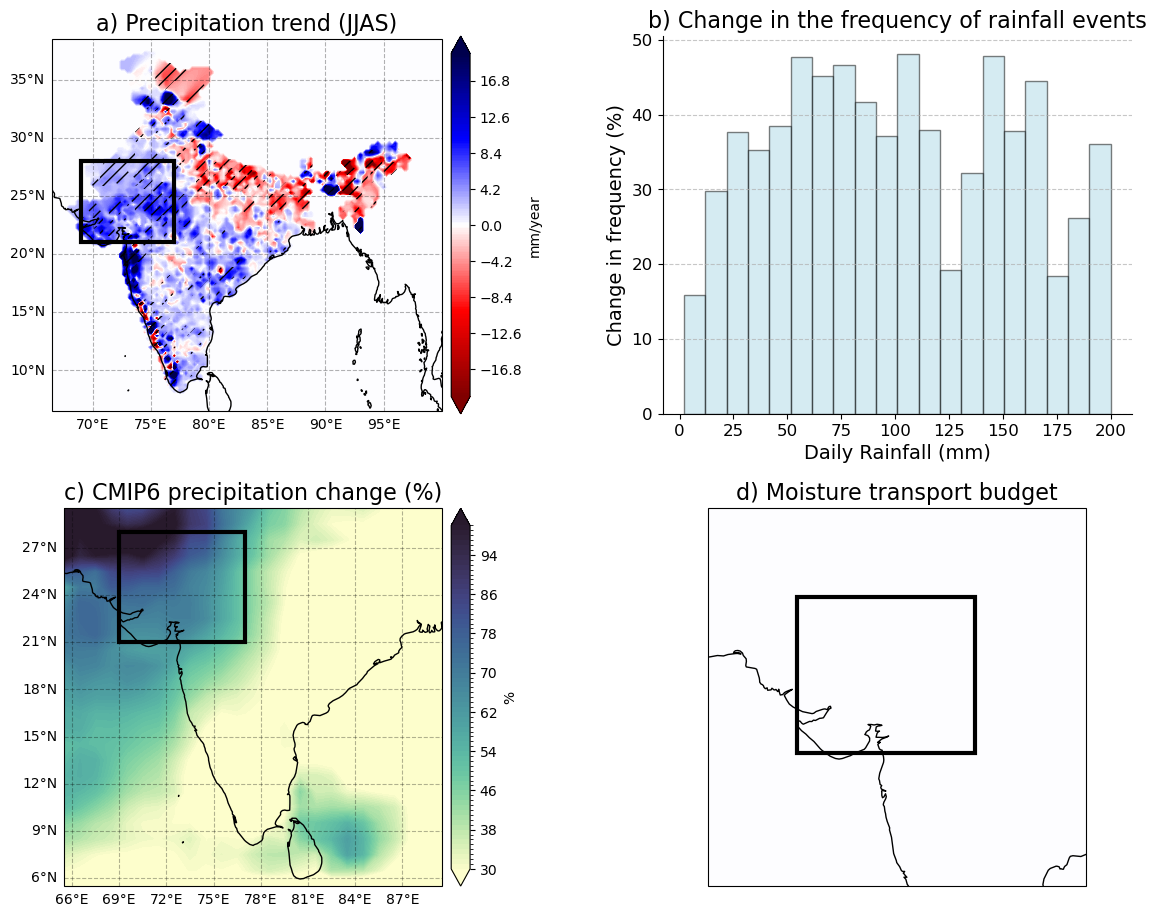

In [182]:
alpha = 0.05
proj = ccrs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Create the first subplot for the map with projection
ax0 = plt.subplot(gs[0, 0], projection=proj)
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0], projection=proj)
ax3 = plt.subplot(gs[1, 1], projection=proj)

# Now you can use ax0 for your map and ax1 for your time series


c0 = ax0.contourf(precip_trend.lon, precip_trend.lat, precip_trend.values, levels=np.arange(-20,20.2,0.2), extend='both', transform=ccrs.PlateCarree(), cmap='seismic_r')
    
# Create a mask for significant correlations
alpha = 0.05
significant_mask = precip_p_value < alpha

    # Add contours for statistically significant correlations
contours = ax0.contourf(significant_mask.lon, significant_mask.lat, significant_mask.values, levels=[0.5, 1], colors='none', hatches=['', '///'], extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)

#diff.plot.hist(ax=ax1, bins=20, edgecolor='black', alpha=1, color='lightblue', range=(2, 200))
# Plot histograms for each time period with improved styling
ax1.bar(bin_centers, relative_difference, width=np.diff(bin_edges), edgecolor='black', alpha=0.5, color='lightblue')
#precip_wi_jjas.RAINFALL.sel(time=slice('1979','1989')).plot.hist(ax=ax1, bins=50, edgecolor='black', alpha=1, color='red', label='1979-1989', range=(2, 100))
#precip_wi_jjas.RAINFALL.sel(time=slice('2012','2022')).plot.hist(ax=ax1, bins=50, edgecolor='darkgreen', alpha=0.5, color='lightgreen', label='2012-2022', range=(2, 100))

# Set plot labels and title
ax1.set_title('b) Change in the frequency of rainfall events', fontsize=16)
ax1.set_xlabel('Daily Rainfall (mm)', fontsize=14)
ax1.set_ylabel('Change in frequency (%)', fontsize=14)
#ax1.set_xlim(0, 60)

# Add legend with improved style
#ax1.legend(fontsize=12)

# Add grid lines for better readability
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Customize tick labels
ax1.tick_params(axis='both', labelsize=12)

# Remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

c2 = cmip_tp.sel(lat=slice(5,30),lon=slice(65,90)).pr_relanom.plot.contourf(ax=ax2, levels=np.arange(30,101,1), extend='both', transform=ccrs.PlateCarree(), cmap='cmo.deep',add_colorbar=False)


c3 = ax3.contourf(mslp_trend.sel(lat=slice(32,15),lon=slice(65,82)).lon, mslp_trend.sel(lat=slice(32,15),lon=slice(65,82)).lat, (mslp_trend*0).sel(lat=slice(32,15),lon=slice(65,82)).values, levels=np.arange(-20,20.2,0.2), extend='both', transform=ccrs.PlateCarree(), cmap='seismic_r')
    

ax0.set_title('a) Precipitation trend (JJAS)', fontsize=16)
ax2.set_title('c) CMIP6 precipitation change (%)', fontsize=16)
ax3.set_title('d) Moisture transport budget', fontsize=16)


ax0.coastlines(resolution='50m',zorder=11)
ax2.coastlines(resolution='50m',zorder=11)
ax3.coastlines(resolution='50m',zorder=11)




gl0 = ax0.gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)
gl2 = ax2.gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)
#gl3 = ax3.gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)

gl0.left_labels=True
gl0.bottom_labels=True
gl2.bottom_labels=True
gl2.left_labels=True
#gl3.left_labels=True
#gl3.bottom_labels=True


plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, wspace=0.3,hspace=0.25)

# Create color bars separately
cb0 = plt.colorbar(c0, ax=ax0, orientation='vertical',pad=0.02)
cb2 = plt.colorbar(c2, ax=ax2, orientation='vertical',pad=0.02)
#cb3 = plt.colorbar(c3, ax=ax3, orientation='vertical',pad=0.02)
ax0.add_patch(
        plt.Rectangle(
            xy=(69, 21),
            width=8,
            height=7,
            linewidth=3,
            edgecolor='k',
            facecolor='none',
            transform=ccrs.PlateCarree()
        ))
ax2.add_patch(
        plt.Rectangle(
            xy=(69, 21),
            width=8,
            height=7,
            linewidth=3,
            edgecolor='k',
            facecolor='none',
            transform=ccrs.PlateCarree()
        ))
ax3.add_patch(
        plt.Rectangle(
            xy=(69, 21),
            width=8,
            height=7,
            linewidth=3,
            edgecolor='k',
            facecolor='none',
            transform=ccrs.PlateCarree()
        ))






cb0.set_label('mm/year')
cb2.set_label('%')
#cb3.set_label('kg/m2/s/decade')


plt.savefig('./Figures/Figure_1_empty_box.pdf', format='pdf', bbox_inches="tight")

### Figure 2

In [183]:
significant_m = xr.where((um_p_value < 0.05) | (vm_p_value < 0.05), True, False)

# Create new DataArrays for u and v trends that only contain significant values
um_trend_significant = xr.where(significant_m, um_trend, np.nan)
vm_trend_significant = xr.where(significant_m, vm_trend, np.nan)

C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\li3n23\AppData\Local\Temp\ipykernel_22168\1595911075.py:80: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, hspace=0.01,wspace=0.02)


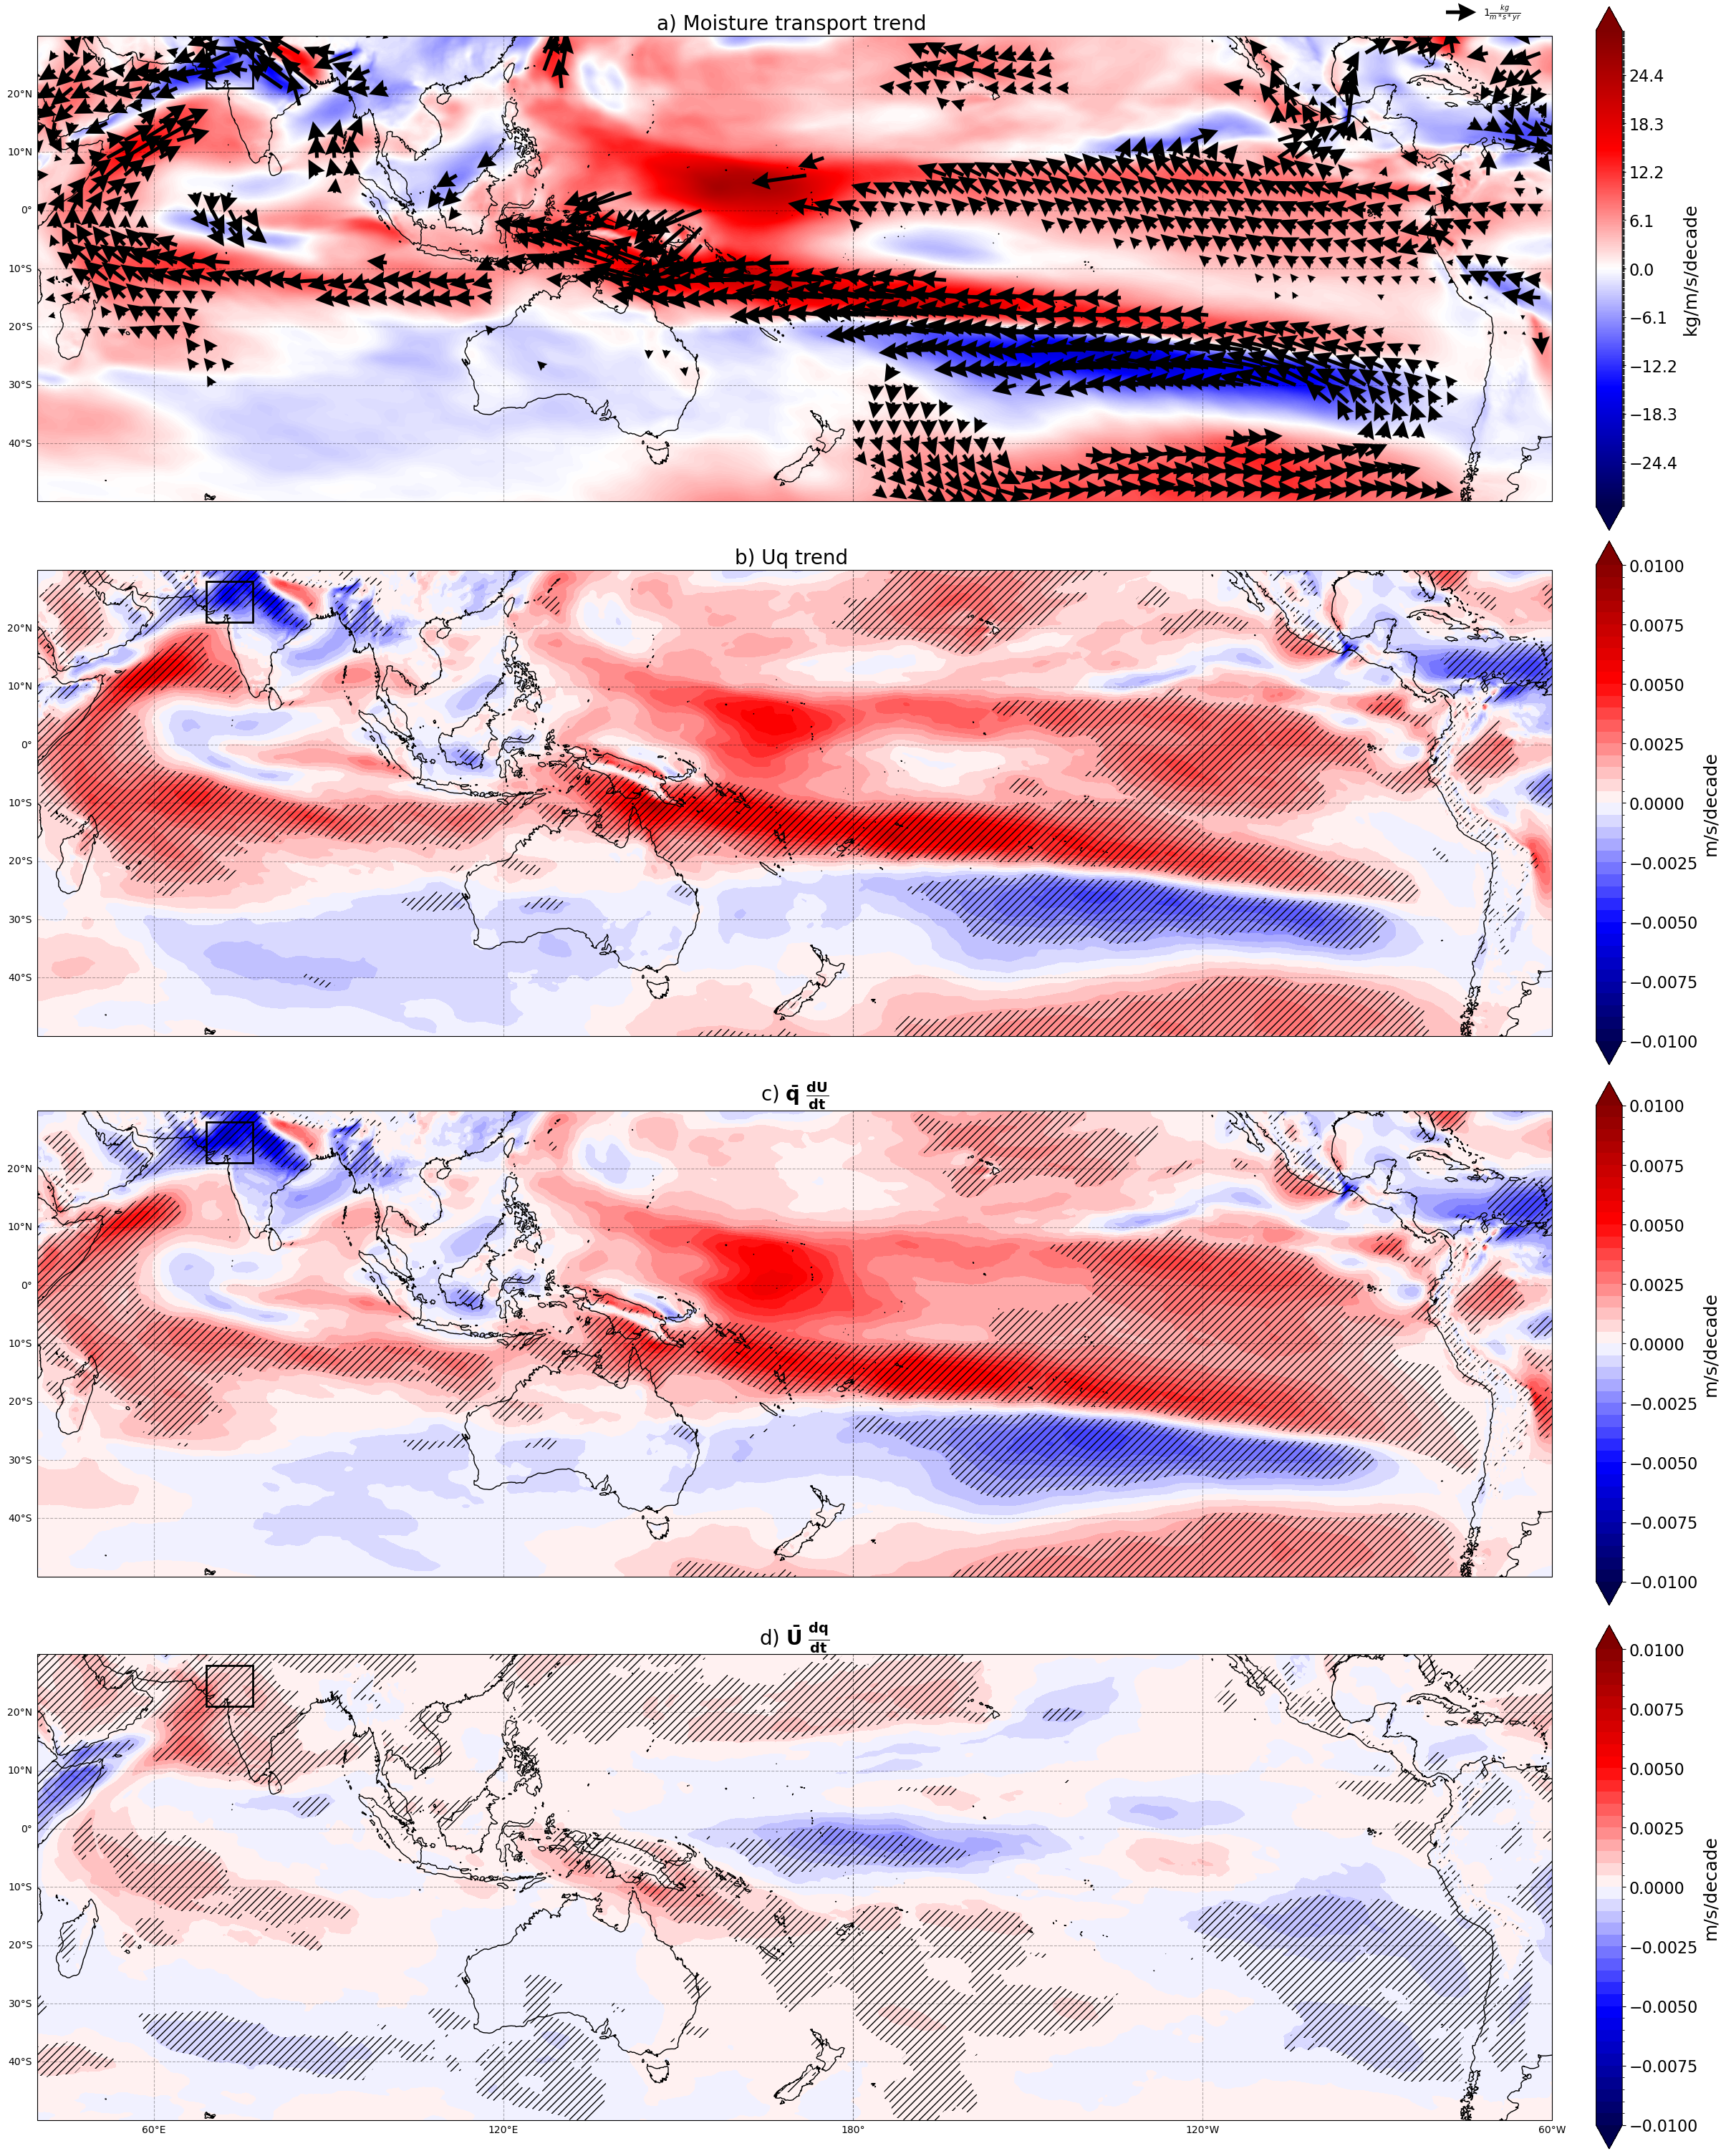

In [184]:
proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(4, 1, figsize=(24, 30), subplot_kw={'projection': proj},constrained_layout=True)

c1 = ((ms_trend*10).sel(lat=slice(30,-50),lon=slice(40,300))).plot.contourf(
        levels=np.arange(-30,30.1,0.1),
        extend='both',
        cmap='seismic',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,ax=axes[0]
    )
q2=axes[0].quiver(um_trend_significant.sel(lat=slice(30,-50),lon=slice(40,300)).lon[::12],um_trend_significant.sel(lat=slice(30,-50),lon=slice(40,300)).lat[::12],um_trend_significant.sel(lat=slice(30,-50),lon=slice(40,300)).sel(lat=slice(30,-50),lon=slice(40,300)).data[::12,::12],vm_trend_significant.sel(lat=slice(30,-50),lon=slice(40,300)).data[::12,::12],scale=50,headwidth=5,headlength=5,transform=ccrs.PlateCarree())
qk2 = axes[0].quiverkey(q2,0.95,1.05,1, r'$1 \frac{kg}{m*s*yr}$', labelpos='E')

c2 = (UQ_trend*10).sel(lat=slice(30,-50)).plot.contourf(
        levels=np.arange(-0.0100,0.0105,0.0005),
        extend='both',
        cmap='seismic',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,ax=axes[1]
    )

UQ_significant_mask = UQ_p_value.sel(lon=slice(40,300),lat=slice(30,-50)) < alpha

# Add contours for statistically significant correlations
contours = axes[1].contourf(UQ_significant_mask.lon, UQ_significant_mask.lat, UQ_significant_mask.values, levels=[0.5, 1], colors='none', hatches=['', '///'], extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)


c3 = (Ubar_Qprime*10).sel(lat=slice(30,-50)).plot.contourf(
        levels=np.arange(-0.0100,0.0105,0.0005),
        extend='both',
        cmap='seismic',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,ax=axes[3]
    )

q_significant_mask = q_p_value.sel(lon=slice(40,300),lat=slice(30,-50)) < alpha

# Add contours for statistically significant correlations
contours = axes[3].contourf(q_significant_mask.lon, q_significant_mask.lat, q_significant_mask.values, levels=[0.5, 1], colors='none', hatches=['', '///'], extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)


c4 = (Qbar_Uprime*10).sel(lat=slice(30,-50)).plot.contourf(
        levels=np.arange(-0.0100,0.0105,0.0005),
        extend='both',
        cmap='seismic',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,ax=axes[2]
)

ws_significant_mask = ws_p_value.sel(lon=slice(40,300),lat=slice(30,-50)) < alpha

# Add contours for statistically significant correlations
contours = axes[2].contourf(ws_significant_mask.lon, ws_significant_mask.lat, ws_significant_mask.values, levels=[0.5, 1], colors='none', hatches=['', '///'], extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)

axes[0].coastlines(resolution='50m',zorder=11)
axes[0].set_title('a) Moisture transport trend ', fontsize=20)

axes[1].coastlines(resolution='50m',zorder=11)
axes[1].set_title('b) Uq trend ', fontsize=20)

axes[2].coastlines(resolution='50m',zorder=11)
axes[3].set_title('d) ' + r'$\mathbf{\bar{U}}$ ' + r'$\mathbf{\frac{dq}{dt}}$', fontsize=20)

axes[3].coastlines(resolution='50m',zorder=11)
axes[2].set_title('c) ' + r'$\mathbf{\bar{q}}$ ' +  r'$\mathbf{\frac{dU}{dt}}$', fontsize=20)
    


gl1 = axes[0].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)
gl2 = axes[1].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)
gl3 = axes[2].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)
gl4 = axes[3].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)

gl1.left_labels=True
gl2.left_labels=True
gl3.left_labels=True
gl4.left_labels=True
gl4.bottom_labels=True

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, hspace=0.01,wspace=0.02)


axes[0].add_patch(
        plt.Rectangle(
            xy=(69, 21),
            width=8,
            height=7,
            linewidth=2,
            edgecolor='k',
            facecolor='none',
            transform=ccrs.PlateCarree()))
axes[1].add_patch(
        plt.Rectangle(
            xy=(69, 21),
            width=8,
            height=7,
            linewidth=2,
            edgecolor='k',
            facecolor='none',
            transform=ccrs.PlateCarree()))
axes[3].add_patch(
        plt.Rectangle(
            xy=(69, 21),
            width=8,
            height=7,
            linewidth=2,
            edgecolor='k',
            facecolor='none',
            transform=ccrs.PlateCarree()))
axes[2].add_patch(
        plt.Rectangle(
            xy=(69, 21),
            width=8,
            height=7,
            linewidth=2,
            edgecolor='k',
            facecolor='none',
             transform=ccrs.PlateCarree()))



#cb1=fig.colorbar(c1,cax=cbar_ax1,orientation='horizontal')
cb1 = plt.colorbar(c1, ax=axes[0], orientation='vertical',pad=0.02,shrink=1)
cb2 = plt.colorbar(c2, ax=axes[1], orientation='vertical',pad=0.02,shrink=1)
cb3 = plt.colorbar(c3, ax=axes[3], orientation='vertical',pad=0.02,shrink=1)
cb4 = plt.colorbar(c4, ax=axes[2], orientation='vertical',pad=0.02,shrink=1)


#cb4 = plt.colorbar(c4, ax=axes[2], orientation='vertical',pad=0.02,shrink=1)


cb1.set_label('kg/m/s/decade',fontsize=18)
cb2.set_label('m/s/decade',fontsize=18)
cb3.set_label('m/s/decade',fontsize=18)
cb4.set_label('m/s/decade',fontsize=18)

cb1.ax.tick_params(labelsize=16)
cb2.ax.tick_params(labelsize=16)
cb3.ax.tick_params(labelsize=16)
cb4.ax.tick_params(labelsize=16)
plt.savefig('./Figures/Figure_2.png', format='png', bbox_inches="tight")

### Figure 3

In [185]:
significant_ws = xr.where((u_p_value < 0.05) | (v_p_value < 0.05), True, False)

# Create new DataArrays for u and v trends that only contain significant values
u_trend_significant = xr.where(significant_ws, u_trend, np.nan)
v_trend_significant = xr.where(significant_ws, v_trend, np.nan)

C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


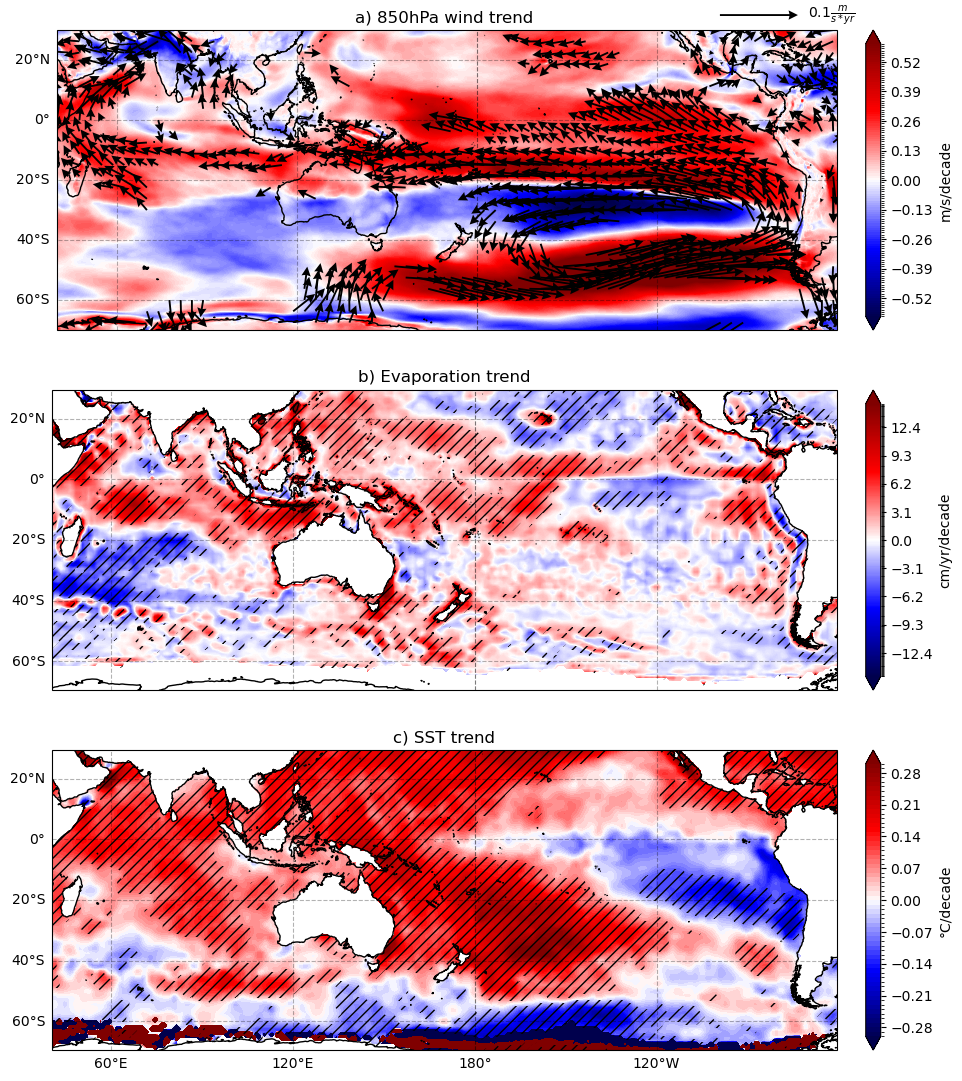

In [193]:
alpha = 0.05
proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(3, 1, figsize=(16, 12), subplot_kw={'projection': proj})

c1 = ((ws_trend.sel(lon=slice(40,300),lat=slice(30,-70)))*10).plot.contourf(
        levels=np.arange(-0.6,0.61,0.01),
        extend='both',
        cmap='seismic',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,ax=axes[0]
    )

q1 = axes[0].quiver(u_jjas.sel(lon=slice(40,300),lat=slice(30,-70)).lon[::15], 
               u_jjas.sel(lon=slice(40,300),lat=slice(30,-70)).lat[::15], 
               u_trend_significant.sel(lon=slice(40,300),lat=slice(30,-70)).data[::15,::15], 
               v_trend_significant.sel(lon=slice(40,300),lat=slice(30,-70)).data[::15,::15],
               scale=1,headwidth=5,headlength=5,transform=ccrs.PlateCarree())

qk1 = axes[0].quiverkey(q1, 0.95, 1.05, 0.1, r'$0.1 \frac{m}{s*yr}$', labelpos='E', coordinates='axes')

c2 = ((evp_trend*10).sel(lat=slice(-70,30),lon=slice(40,300))).plot.contourf(
        levels=np.arange(-15,15.1,0.1),
        extend='both',
        cmap='seismic',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        ax=axes[1]
    )

evp_significant_mask = evp_p_value.sel(lon=slice(40,300),lat=slice(-70,30)) < 0.05

# Add contours for statistically significant correlations
contours = axes[1].contourf(evp_significant_mask.lon, evp_significant_mask.lat, evp_significant_mask.values, levels=[0.5, 1], colors='none', hatches=['', '///'], extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)


c3 = (sst_trend.sel(lon=slice(40,300),lat=slice(30,-70))*10).plot.contourf(ax=axes[2], levels=np.arange(-0.3,0.31,0.01), extend='both', transform=ccrs.PlateCarree(), cmap='seismic',add_colorbar=False)
#axes[2].scatter(lon_sst[::8], lat_sst[::8], color='black', s=0.5, alpha=0.3,transform=ccrs.PlateCarree())

sst_significant_mask = sst_p_value.sel(lon=slice(40,300),lat=slice(30,-70)) < alpha

# Add contours for statistically significant correlations
contours = axes[2].contourf(sst_significant_mask.lon, sst_significant_mask.lat, sst_significant_mask.values, levels=[0.5, 1], colors='none', hatches=['', '///'], extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)

axes[0].coastlines(resolution='50m',zorder=11)
axes[0].set_title('a) 850hPa wind trend ')

axes[1].coastlines(resolution='50m',zorder=11)
axes[1].set_title('b) Evaporation trend')

axes[2].coastlines(resolution='50m',zorder=11)
axes[2].set_title('c) SST trend')




gl1 = axes[0].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)
gl2 = axes[1].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)
gl3 = axes[2].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)

gl1.left_labels=True
gl2.left_labels=True
gl3.left_labels=True
gl3.bottom_labels=True
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, hspace=0.2)

# Create color bars separately
cb1 = plt.colorbar(c1, ax=axes[0], orientation='vertical',pad=0.02)
cb2 = plt.colorbar(c2, ax=axes[1], orientation='vertical',pad=0.02)
cb3 = plt.colorbar(c3, ax=axes[2], orientation='vertical',pad=0.02)


cb1.set_label('m/s/decade')
cb2.set_label('cm/yr/decade')
cb3.set_label('\u00b0C/decade')



plt.savefig('./Figures/Figure_3.png', format='png', bbox_inches="tight")

### Figure 4

C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


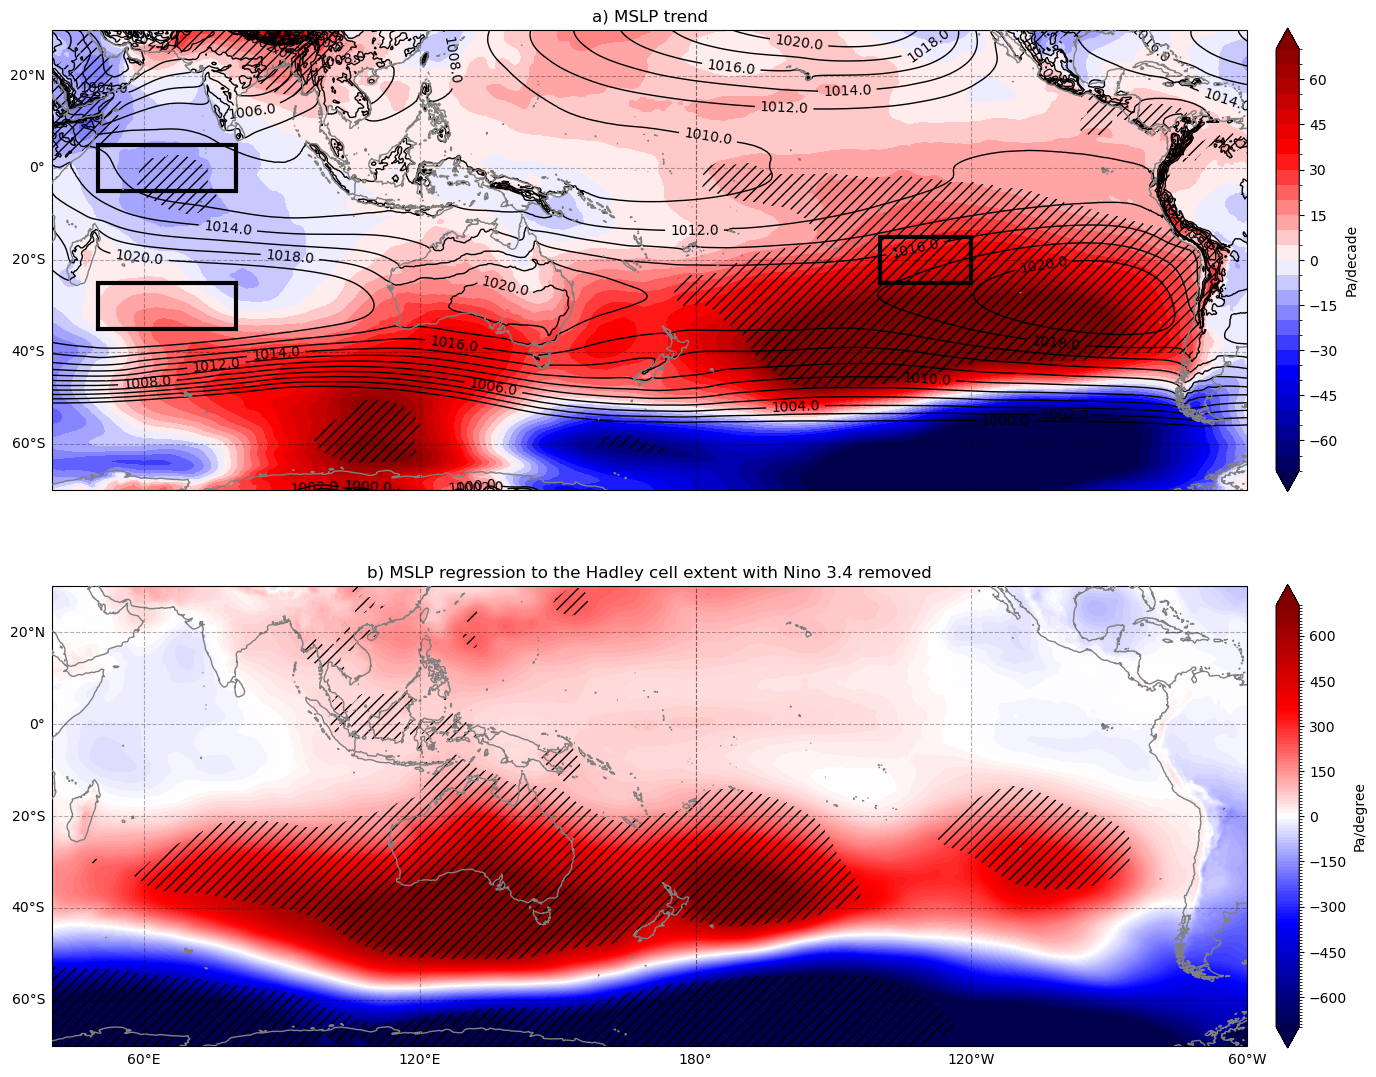

In [194]:
alpha = 0.05
proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(2, 1, figsize=(16, 12), subplot_kw={'projection': proj})


c1 = (mslp_trend.sel(lon=slice(40,300),lat=slice(30,-70))*10).plot.contourf(ax=axes[0], levels=np.arange(-70,75,5), extend='both', transform=ccrs.PlateCarree(), cmap='seismic',add_colorbar=False)

c1c = ((mslp_jjas.mean('year') / 100).sel(lon=slice(40, 300), lat=slice(30, -70))).plot.contour(
    ax=axes[0],
    levels=np.arange(1000, 1022, 2),  # Specify the pressure levels here
    extend='both',
    transform=ccrs.PlateCarree(),
    colors='black',  # Set contour line color
    linewidths=1,  # Adjust the width of contour lines as needed
)

mslp_significant_mask = mslp_p_value.sel(lon=slice(40,300),lat=slice(30,-70)) < alpha

# Add contours for statistically significant correlations
contours = axes[0].contourf(mslp_significant_mask.lon, mslp_significant_mask.lat, mslp_significant_mask.values, levels=[0.5, 1], colors='none', hatches=['', '///'], extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)


c2 = ((slope_hadley_detrend_no*4).sel(lon=slice(40,300),lat=slice(30,-70))).plot.contourf(ax=axes[1], levels=np.arange(-700,710,10), extend='both', transform=ccrs.PlateCarree(), cmap='seismic',add_colorbar=False)

hadley_significant_mask = p_hadley_detrend_no.sel(lon=slice(40,300),lat=slice(30,-70)) < alpha
contours = axes[1].contourf(hadley_significant_mask.lon, hadley_significant_mask.lat, hadley_significant_mask.values, levels=[0.5, 1], colors='none', hatches=['', '///'], extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)


axes[0].coastlines(resolution='50m',zorder=11,color='grey')
axes[0].set_title('a) MSLP trend')

axes[1].coastlines(resolution='50m',zorder=11,color='grey')
axes[1].set_title('b) MSLP regression to the Hadley cell extent with Nino 3.4 removed')




gl1 = axes[0].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)
gl2 = axes[1].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)

gl1.left_labels=True
gl2.left_labels=True
gl2.bottom_labels=True
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, hspace=0.2)

# Create color bars separately
cb1 = plt.colorbar(c1, ax=axes[0], orientation='vertical',pad=0.02)
cb2 = plt.colorbar(c2, ax=axes[1], orientation='vertical',pad=0.02)


cb1.set_label('Pa/decade')
cb2.set_label('Pa/degree')
plt.clabel(c1c, fmt='%1.1f') 



axes[0].add_patch(
        plt.Rectangle(
            xy=(50, -35),
            width=30,
            height=10,
            linewidth=3,
            edgecolor='k',
            facecolor='none',
            transform=ccrs.PlateCarree()
        ))

axes[0].add_patch(
        plt.Rectangle(
            xy=(50, -5),
            width=30,
            height=10,
            linewidth=3,
            edgecolor='k',
            facecolor='none',
            transform=ccrs.PlateCarree()
        ))
mslp_PO = mslp_jjas.sel(lat=slice(-15,-25),lon=slice(220,240)).mean(['lat','lon'])

axes[0].add_patch(
        plt.Rectangle(
            xy=(220, -25),
            width=20,
            height=10,
            linewidth=3,
            edgecolor='k',
            facecolor='none',
            transform=ccrs.PlateCarree()
        ))

plt.savefig('./Figures/Figure_4.png', format='png', bbox_inches="tight")

### Figure 5

In [195]:
mslp_MH = mslp_jjas.sel(lat=slice(-25,-35),lon=slice(50,80)).mean(['lat','lon'])
mslp_IO = mslp_jjas.sel(lat=slice(5,-5),lon=slice(50,80)).mean(['lat','lon'])
mslp_PO = mslp_jjas.sel(lat=slice(-15,-25),lon=slice(220,240)).mean(['lat','lon'])

mslp_diff_zonal = mslp_PO-mslp_IO
mslp_diff_mer = mslp_MH-mslp_IO

slope_mslp_diff_mer, intercept_mslp_diff_mer, r_value_mslp_diff_mer, p_value_mslp_diff_mer, std_err_mslp_diff_mer = linregress(mslp_diff_mer.year, mslp_diff_mer)
trend_mslp_diff_mer = intercept_mslp_diff_mer + slope_mslp_diff_mer * mslp_diff_mer.year

slope_mslp_diff, intercept_mslp_diff, r_value_mslp_diff, p_value_mslp_diff, std_err_mslp_diff = linregress(mslp_diff_zonal.year, mslp_diff_zonal)
trend_mslp_diff = intercept_mslp_diff + slope_mslp_diff * mslp_diff_zonal.year

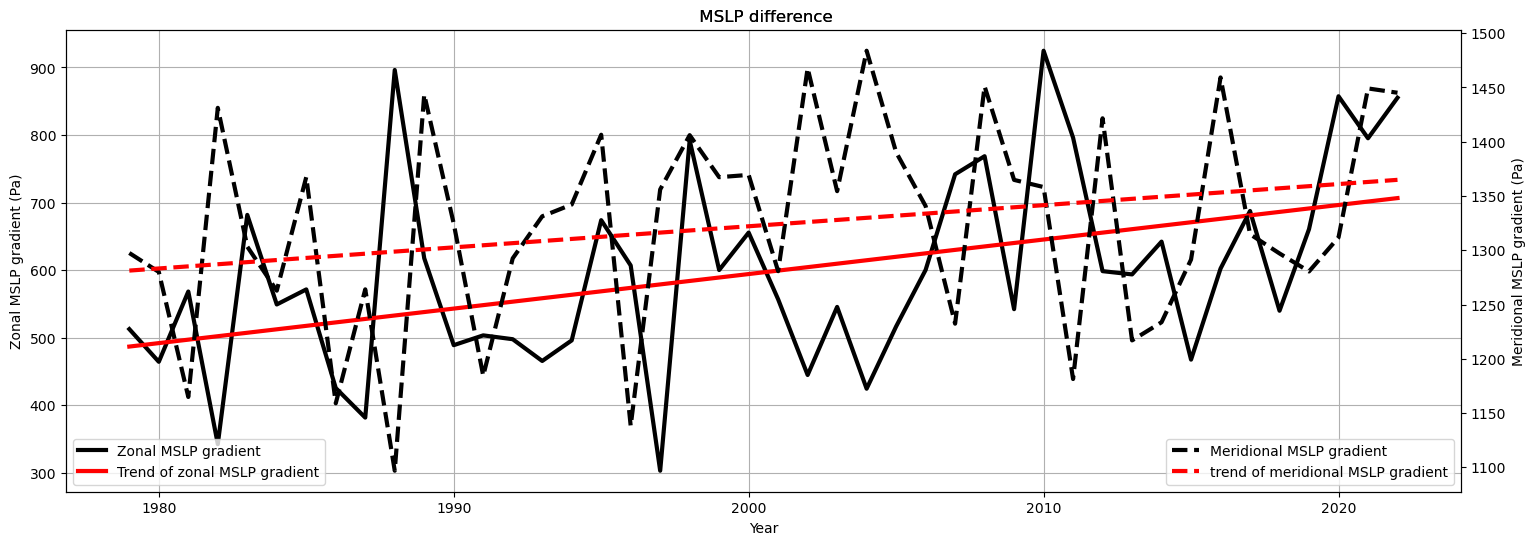

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(18,6))

# Second plot
ax.plot(mslp_diff_zonal.year,mslp_diff_zonal,linewidth=3,color='black',label='Zonal MSLP gradient')
ax.plot(mslp_diff_zonal.year,trend_mslp_diff,linewidth=3,color='red',label='Trend of zonal MSLP gradient')
ax.legend(loc='lower left')
ax.set_ylabel('Zonal MSLP gradient (Pa)')
ax.set_title(' MSLP difference')
ax.grid(True)
ax.set_xlabel('Year')

ax1=ax.twinx()
ax1.plot(mslp_diff_mer.year,mslp_diff_mer,linewidth=3,color='black',label='Meridional MSLP gradient',ls='--')
ax1.plot(mslp_diff_mer.year,trend_mslp_diff_mer,linewidth=3,color='red',label='trend of meridional MSLP gradient',ls='--')
ax1.legend(loc='lower right')
ax1.set_ylabel('Meridional MSLP gradient (Pa)')
ax1.set_title(' MSLP difference')
#ax1.grid(True)
ax1.set_xlabel('Year')


plt.savefig('./Figures/Figure_5.png', format='png', bbox_inches="tight")

### Figure 6

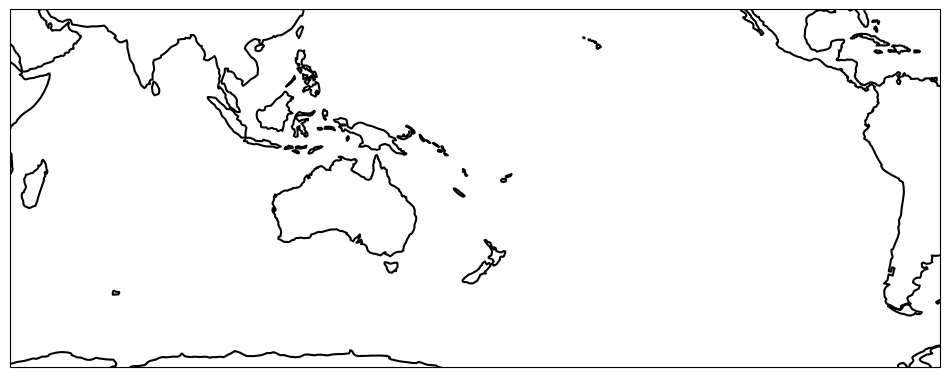

In [197]:
# Define the projection (Plate Carree)
proj = ccrs.PlateCarree(central_longitude=180)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 52), subplot_kw={'projection': proj})

# Set the extent based on the provided latitude and longitude ranges
ax.set_extent([40, 300, -70, 30], crs=ccrs.PlateCarree())

# Plot coastlines
ax.coastlines(resolution='110m', color='black',linewidth=1.5)

# Add gridlines
#ax.gridlines(draw_labels=True, linestyle='--',zorde)

# Set title and labels


# Show the plot
#plt.show()
plt.savefig('./Figures/Figure_6.png', format='png', bbox_inches="tight")

### Figure S1

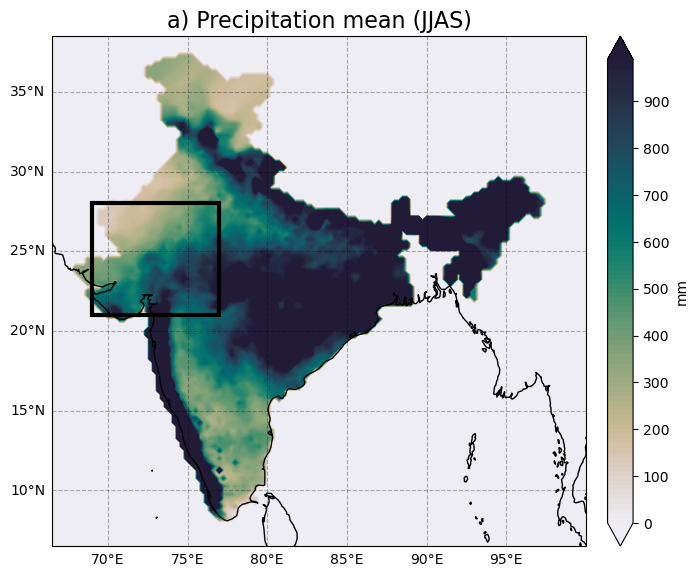

In [198]:
alpha = 0.05
proj = ccrs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(12,6))
# Create the first subplot for the map with projection
ax0 = plt.subplot(projection=proj)

# Now you can use ax0 for your map and ax1 for your time series


c0 = ax0.contourf(precip_jjas.lon, precip_jjas.lat, precip_jjas.mean('year').values, levels=np.arange(0,1000,10), extend='both', transform=ccrs.PlateCarree(), cmap='cmo.rain')
    
# Create a mask for significant correlations


ax0.set_title('a) Precipitation mean (JJAS)', fontsize=16)



ax0.coastlines(resolution='50m',zorder=11)



gl0 = ax0.gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)


gl0.left_labels=True
gl0.bottom_labels=True


plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, wspace=0.3)

# Create color bars separately
cb0 = plt.colorbar(c0, ax=ax0, orientation='vertical',pad=0.02)

ax0.add_patch(
        plt.Rectangle(
            xy=(69, 21),
            width=8,
            height=7,
            linewidth=3,
            edgecolor='k',
            facecolor='none',
            transform=ccrs.PlateCarree()
        ))







cb0.set_label('mm')



plt.savefig('./Figures/Figure_S1.png', format='png', bbox_inches="tight")

### Figure S2

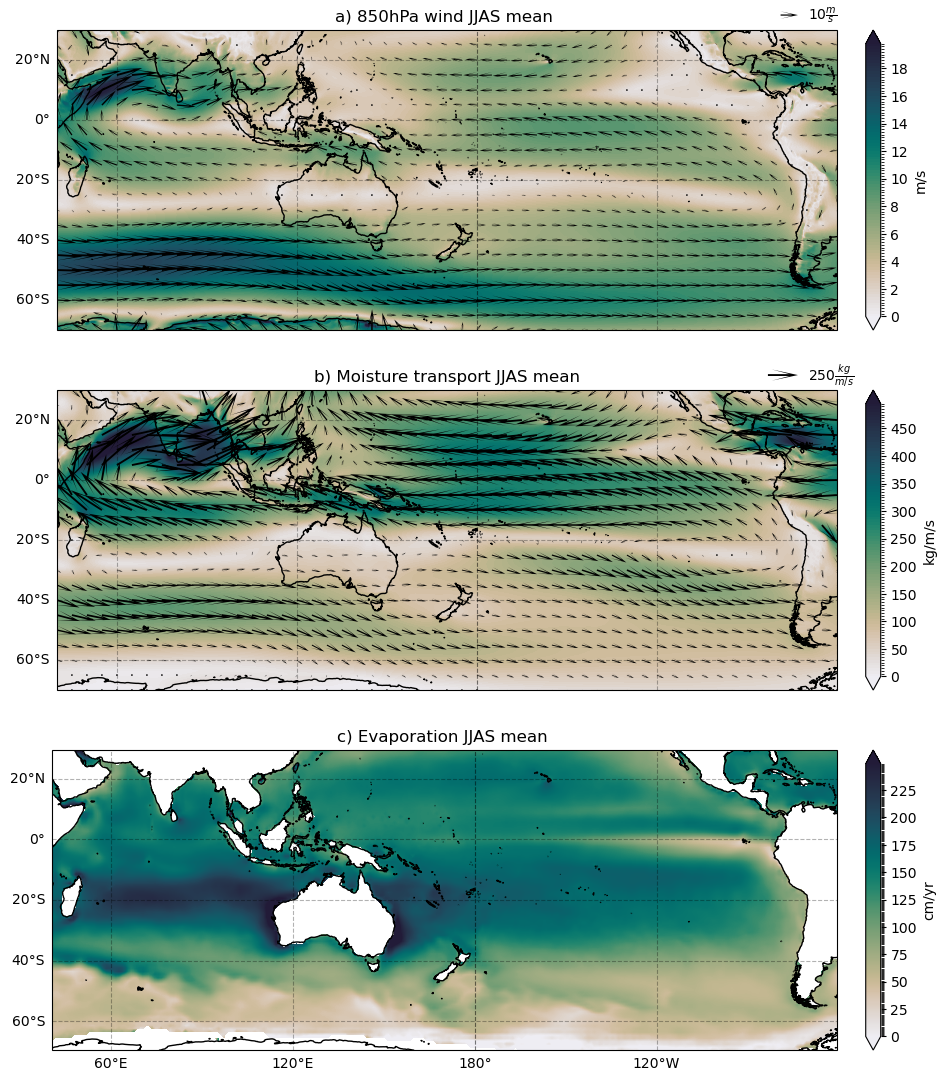

In [199]:
alpha = 0.05
proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(3, 1, figsize=(16, 12), subplot_kw={'projection': proj})

c1 = ((wind_speed.mean('year').sel(lon=slice(40,300),lat=slice(30,-70)))).plot.contourf(
        levels=np.arange(0,20,0.2),
        extend='both',
        cmap='cmo.rain',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,ax=axes[0]
    )

q1 = axes[0].quiver(u_jjas.sel(lon=slice(40,300),lat=slice(30,-70)).lon[::20], 
               u_jjas.sel(lon=slice(40,300),lat=slice(30,-70)).lat[::20], 
               u_jjas.mean('year').sel(lon=slice(40,300),lat=slice(30,-70)).data[::20,::20], 
               v_jjas.mean('year').sel(lon=slice(40,300),lat=slice(30,-70)).data[::20,::20],
               scale=450,headwidth=6,headlength=14,transform=ccrs.PlateCarree())

qk1 = axes[0].quiverkey(q1, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E', coordinates='axes')

c2 = (mois_mag_jjas.mean('year').sel(lat=slice(30,-70),lon=slice(40,300))).plot.contourf(
        levels=np.arange(0,500,5),
        extend='both',
        cmap='cmo.rain',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        ax=axes[1]
    )
q2=axes[1].quiver(um_jjas.sel(lat=slice(30,-70),lon=slice(40,300)).lon[::20],um_jjas.sel(lat=slice(30,-70),lon=slice(40,300)).lat[::20],um_jjas.mean('year').sel(lat=slice(30,-70),lon=slice(40,300)).data[::20,::20],vm_jjas.mean('year').sel(lat=slice(30,-70),lon=slice(40,300)).data[::20,::20],scale=6500,headwidth=6,headlength=14,transform=ccrs.PlateCarree())
qk2 = axes[1].quiverkey(q2, 0.95, 1.05, 250, r'$250 \frac{kg}{m/s}$', labelpos='E', coordinates='axes')

c3 = ((evp_jjas_oa.mean('year').sel(lon=slice(40,300),lat=slice(-70,30)))).plot.contourf(
        levels=np.arange(0,250,1),
        extend='both',
        cmap='cmo.rain',
        transform=ccrs.PlateCarree(),
        add_colorbar=False,ax=axes[2]
    )

axes[0].coastlines(resolution='50m',zorder=11)
axes[0].set_title('a) 850hPa wind JJAS mean ')

axes[1].coastlines(resolution='50m',zorder=11)
axes[1].set_title('b) Moisture transport JJAS mean')

axes[2].coastlines(resolution='50m',zorder=11)
axes[2].set_title('c) Evaporation JJAS mean ')

gl1 = axes[0].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)
gl2 = axes[1].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)
gl3 = axes[2].gridlines(draw_labels=False,alpha=0.3,linestyle='--',color='k',zorder=11)

gl1.left_labels=True
gl2.left_labels=True
gl3.left_labels=True
gl3.bottom_labels=True
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95, hspace=0.2)

# Create color bars separately
cb1 = plt.colorbar(c1, ax=axes[0], orientation='vertical',pad=0.02)
cb2 = plt.colorbar(c2, ax=axes[1], orientation='vertical',pad=0.02)
cb3 = plt.colorbar(c3, ax=axes[2], orientation='vertical',pad=0.02)

cb3.set_label('cm/yr')
cb1.set_label('m/s')
cb2.set_label('kg/m/s')



plt.savefig('./Figures/Figure_S2.png', format='png', bbox_inches="tight")

### Figure S3

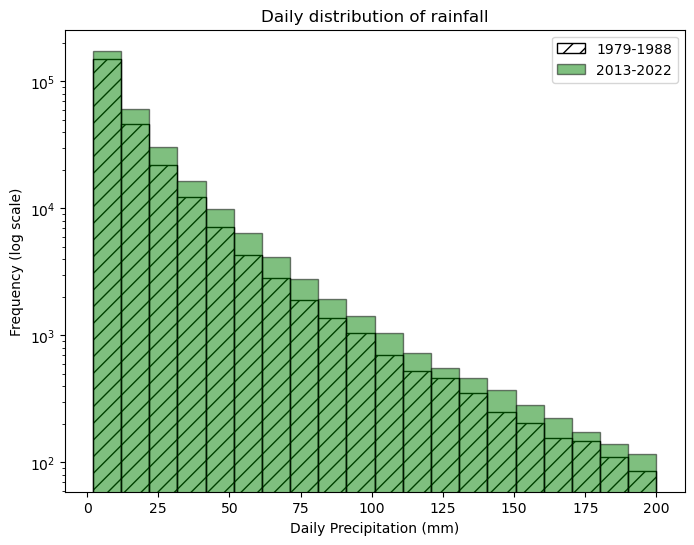

<Figure size 640x480 with 0 Axes>

In [200]:


# Calculate histograms for each time period
hist1, bin_edges = np.histogram(precip_wi_jjas.RAINFALL.sel(time=slice('1979','1988')), bins=20, range=(2, 200))
hist2, _ = np.histogram(precip_wi_jjas.RAINFALL.sel(time=slice('2013','2022')), bins=20, range=(2, 200))

# Calculate bin centers
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

# Plot hist1 and hist2 in a single plot
plt.figure(figsize=(8, 6))
plt.bar(bin_centers, hist1, width=np.diff(bin_edges), edgecolor='black',color='white', alpha=1, label='1979-1988',hatch='//')
plt.bar(bin_centers, hist2, width=np.diff(bin_edges), edgecolor='black', alpha=0.5, color='green', label='2013-2022')
plt.xlabel('Daily Precipitation (mm)')
plt.ylabel('Frequency (log scale)')
plt.title('Daily distribution of rainfall')
plt.yscale('log')
plt.legend()
plt.show()
plt.savefig('./Figures/Figure_S3.png', format='png', bbox_inches="tight")

### Figure S4

In [201]:
dates = xr.cftime_range(start='1957-01-01', periods=804, freq='MS')
dates_n = dates.to_datetimeindex()
df_SAM = pd.read_csv( '../Data/Observations/SAM.txt',header=None,delim_whitespace=True,engine='python')
df_SAM = df_SAM.set_index(df_SAM.columns[0])
SAM = xr.DataArray(df_SAM.stack())
SAM = SAM.assign_coords(dim_0=dates_n)
SAM = SAM.rename({'dim_0': 'time'})
SAM=SAM.sel(time=slice('1979-01-01','2022-12-01'))
SAM_jjas = calculate_seasonal_means_precip(SAM).groupby('time.year').mean()

C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\xarray\core\common.py:615: FutureWarning: Updating MultiIndexed coordinate 'dim_0' would corrupt indices for other variables: ['dim_0_level_0', 'dim_0_level_1']. This will raise an error in the future. Use `.drop_vars({'dim_0_level_1', 'dim_0_level_0', 'dim_0'})` before assigning new coordinate values.
  data.coords.update(results)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


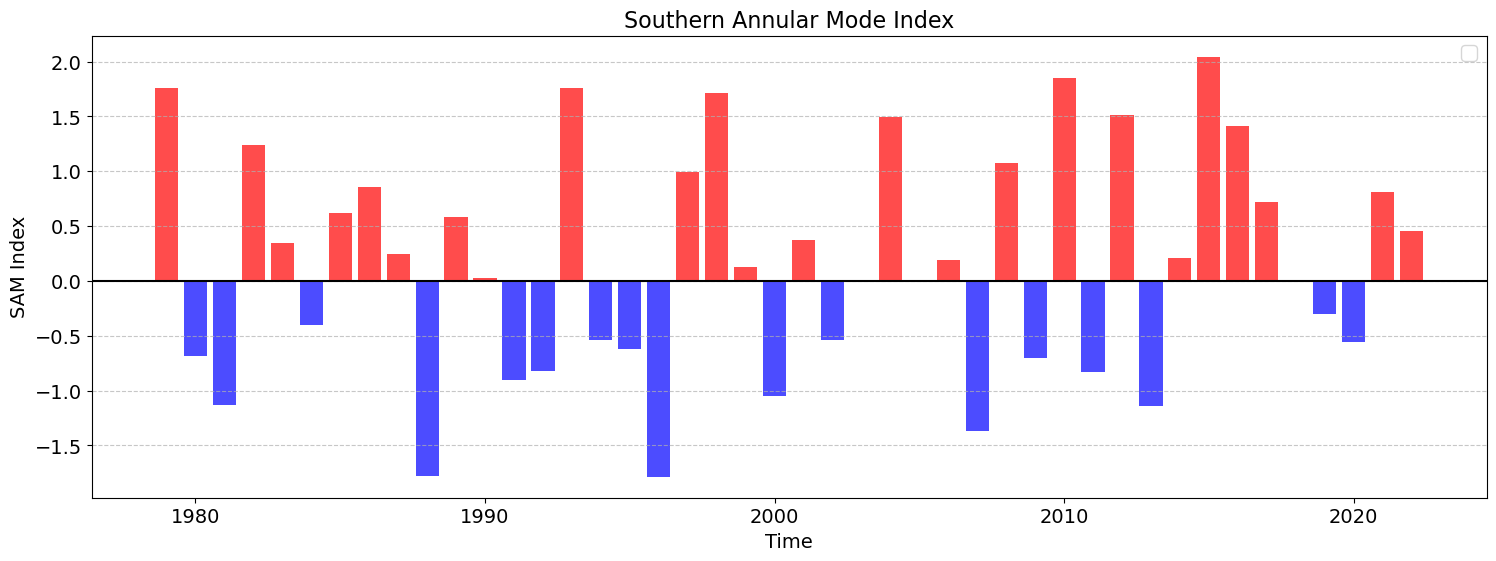

In [204]:
x = SAM_jjas.year
fig, ax = plt.subplots(1, 1, figsize=(18,6))
# Set the style of seaborn for better aesthetics
# Create an array for the x values
# Separate positive and negative values
positive_values = np.maximum(SAM_jjas, 0)
negative_values = np.minimum(SAM_jjas, 0)

# Create bar plots
ax.bar(x, positive_values, color='red', alpha=0.7)
ax.bar(x, negative_values, color='blue', alpha=0.7)

# Calculate trend line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, SAM_jjas)
#ax.plot(x, intercept + slope*x, 'k--', label='Trend line')

# Add a vertical line at x=0
plt.axhline(0, color='black')

# Add labels and title
ax.set_xlabel('Time',fontsize=14)
ax.set_ylabel('SAM Index',fontsize=14)
ax.set_title('Southern Annular Mode Index',fontsize=16)
ax.legend(fontsize=14)

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Customize tick labels
ax.tick_params(axis='both', labelsize=14)
plt.savefig('./Figures/Figure_S4.png', format='png', bbox_inches="tight")

### Figure S5

In [205]:
result_sam = xr.apply_ufunc(
    linear_regression_p,
    SAM_jjas,
    mslp_no_nino_jjas,
    input_core_dims=[['year'], ['year']],
    vectorize=True,
    output_core_dims=[(), ()],  # Define the output core dimensions as empty tuples
    dask='parallelized',  # Use 'parallelized' for better performance with dask arrays
)
slope_sam_detrend, p_sam_detrend = result_sam

C:\Users\li3n23\miniforge3\envs\Work\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


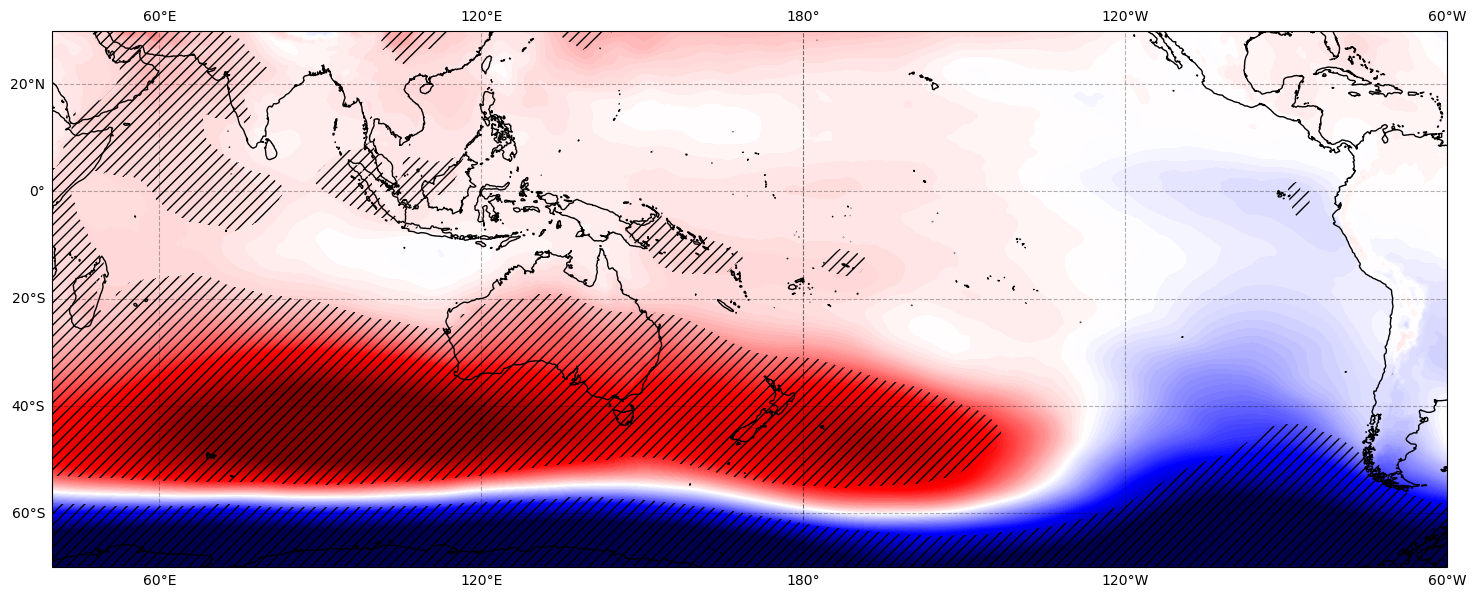

In [207]:
proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(1, 1, figsize=(18, 12), subplot_kw={'projection': proj})
c3 = ((slope_sam_detrend*4).sel(lon=slice(40,300),lat=slice(30,-70))).plot.contourf(ax=ax, levels=np.arange(-700,710,10), extend='both', transform=ccrs.PlateCarree(), cmap='seismic',add_colorbar=False)

sam_significant_mask = p_sam_detrend.sel(lon=slice(40,300),lat=slice(30,-70)) < 0.05
contours = ax.contourf(sam_significant_mask.lon, sam_significant_mask.lat, sam_significant_mask.values, levels=[0.5, 1], colors='none', hatches=['', '///'], extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines(resolution='50m',zorder=11)
ax.gridlines(draw_labels=True,alpha=0.3,linestyle='--',color='k',zorder=11)
plt.title('')
plt.savefig('./Figures/Figure_S5.png', format='png', bbox_inches="tight")

### Figure S6

In [208]:
nino_jjas = calculate_seasonal_means_precip(nino).groupby('time.year').mean()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


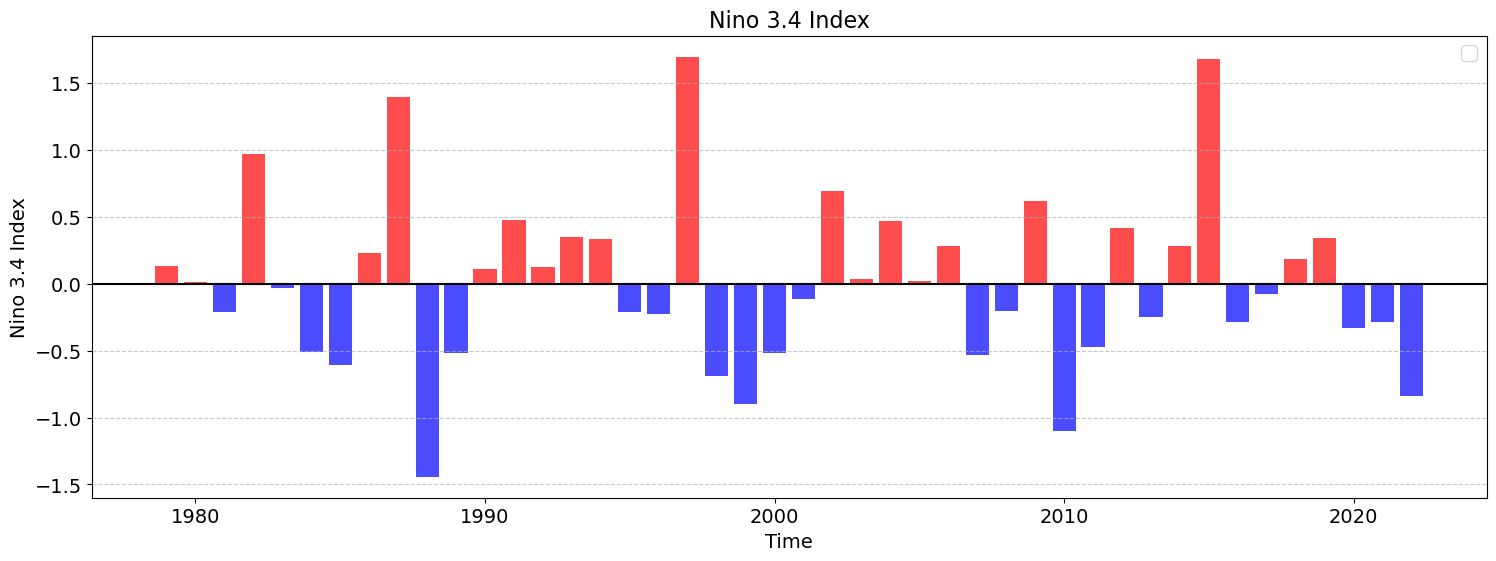

In [209]:

fig, ax = plt.subplots(1, 1, figsize=(18,6))
# Set the style of seaborn for better aesthetics
# Create an array for the x values
# Separate positive and negative values
positive_values = np.maximum(nino_jjas, 0)
negative_values = np.minimum(nino_jjas, 0)

# Create bar plots
ax.bar(x, positive_values, color='red', alpha=0.7)
ax.bar(x, negative_values, color='blue', alpha=0.7)

# Calculate trend line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, nino_jjas)
#ax.plot(x, intercept + slope*x, 'k--', label='Trend line')

# Add a vertical line at x=0
plt.axhline(0, color='black')

# Add labels and title
ax.set_xlabel('Time',fontsize=14)
ax.set_ylabel('Nino 3.4 Index',fontsize=14)
ax.set_title('Nino 3.4 Index',fontsize=16)
ax.legend(fontsize=14)

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Customize tick labels
ax.tick_params(axis='both', labelsize=14)
plt.savefig('./Figures/Figure_S6.png', format='png', bbox_inches="tight")